In [1]:
import matplotlib.pyplot as plt # for plotting maps
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
from statistics import mean, median
from functools import reduce
import matplotlib.pyplot as plt
from textwrap import wrap
from collections import defaultdict, Counter
import re # for some fun processing
import os # because we are storing shapefiles in a few different dirs
import pickle as pkl

from IPython.display import clear_output

%matplotlib inline

pd.set_option("display.max_rows", 150)
pd.set_option("display.max_columns", 150)
plt.rcParams.update({'figure.max_open_warning': 0})



DATA_PATH = "raw-from-source/"
CRS = 3857

county2shape_cache = {}

/Users/SamSpinner/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### General Summary:


#### VEST Documentation

-----
*Election results from the Vermont Secretary of State (https://vtelectionarchive.sec.state.vt.us/)
Shapefile from intersecting the Census county subdivision and State House maps.*

*Vermont has four unorganized towns whose residents cast votes in neighboring towns. These were distributed back based on voting age population in the 2017 American Community Survey as 2018 ACS estimates are not available at the township level. (Averill-Canaan, Buels Gore-Huntington, Ferdinand-Brighton, Glastenbury-Shaftsbury.)*


#### VEST Data

----

VEST dataframe, **vt_2018.sh** downloaded [here](https://dataverse.harvard.edu/dataverse/electionscience/?q=vt_2018).


#### Raw Election Data

----
Election results pulled from .pdf file that was located by navigating to [this site](https://sos.vermont.gov/elections/election-info-resources/elections-results-data/), scrolling down to '2018 General Election Results Official', and clicking on **'2018 GE Official Canvass Report'**. 

The election data comes in the form of tables within a .pdf, with each table representating a county's precinct-level votes for a particular office. The tables could be spread across 1, 2, or 4 pages, depending on the number of precincts within a county and the number of people running in the election. The code to process the .pdf data and convert it to a usable .csv is within **pdf-table-conversion.ipynb**.


#### Raw Shapefile Data

---- 
Follwing VEST's documentation, the precinct shapefiles were created by 'intersecting' the [census county subdivision](https://geodata.vermont.gov/datasets/vt-2010-census-county-subdivision-boundaries-and-statistics?geometry=-79.473%2C42.477%2C-65.410%2C45.249) shapefiles with the [state house map subdivision](https://geodata.vermont.gov/datasets/vt-data-vermont-house-districts-2012?geometry=-79.473%2C42.477%2C-65.410%2C45.249) shapefiles. 

The 'intersect' operation in this case involves dividing one shapefile's geometry boundaries by another shapefiile's geometries, while maintaining the boundaries of the original shapefile. It will in practice produce more precint shapefiles than were contained in either shapefile to begin with.


#### Summary

----

We were successfully able to validate VEST's precinct shapefiles, and the total vote counts for each county. However, there were 60/284 VEST precincts that contained data for a precinct split over multiple smaller precincts. This split of votes between the sub-precincts was not proportional across each race, so VEST could not have been using population estimates to justify the splits. At this time, we are unaware of how VEST acquired election results for these sub-precincts, which will be explicitly shown later in this notebook. 

### Part 1: Election data.

#### Load in Datasets and begin processing/renaming for election-data merge.

In [2]:
master_vest_df = gp.read_file("raw-from-source/vest/vt_2018.shp")
master_sos_df = pd.read_csv("raw-from-source/recreated/vest_from_pdf.csv")

In [3]:
vest_df = master_vest_df.copy().to_crs(CRS)
vest_df.reset_index(inplace=True)

sos_df = master_sos_df.copy()

county_sos = sos_df[sos_df["NAME"] == "County Total"]
sos_df = sos_df[sos_df["NAME"] != "County Total"]

sorted_vest_vote_cols = ["ID", "NAME", "County"] + [col for col in vest_df.columns.to_list() if col.startswith("G18")]
sos_df = sos_df[sorted_vest_vote_cols]

sos_df["ID"] = sos_df["ID"].str.replace("SAINT", "ST.")

#### Create unique ID fields for VEST as you did for the raw data:

In [4]:
# Need to create a verbose unique ID
vest_df["UNIQUE_ID"] = vest_df["NAME"] + " " + vest_df["NAMELSAD"] + " " + vest_df["SLDLST"]

for col in vest_df.columns:
    if not col.startswith("G18"):
        continue
    vest_df[col] = vest_df[col].astype('str')

fp2county = {l.split(',')[1].strip() : l.split(',')[0].split()[0] for l in \
                 open("raw-from-source/utils/fp2county.txt", "r").readlines()}

vest_df["COUNTY"] = vest_df["COUNTYFP"].apply(lambda fp: fp2county[fp])
vest_df["ID"] = vest_df["COUNTY"] + " " + vest_df["NAME"].str.upper()


vest_df = vest_df.sort_values(by="ID")

#### Compare number of precincts between raw data and VEST. VEST has more precincts. 

In [5]:
print("VEST prcs:", len(vest_df["UNIQUE_ID"]))
print("Unique VEST prc NAMEs:", len(vest_df["UNIQUE_ID"].unique()))
print()
print("RAW prcs:", len(sos_df["ID"]))
print("Unique RAW prc IDs:", len(sos_df["ID"].unique()))

VEST prcs: 284
Unique VEST prc NAMEs: 284

RAW prcs: 246
Unique RAW prc IDs: 246


#### Rename precincts to match between VEST and raw data. 

In [6]:
vest_df.loc[200, "ID"] = "Washington BARRE CITY"
vest_df.loc[195, "ID"] = "Washington BARRE TOWN"
vest_df.loc[245, "ID"] = "Franklin ST. ALBANS CITY"
vest_df.loc[79, "ID"] = "Franklin ST. ALBANS TOWN"
vest_df.loc[78, "ID"] = "Franklin ST. ALBANS TOWN"
vest_df.loc[133, "ID"] = "Isle ALBURGH"
vest_df.loc[134, "ID"] = "Isle GRAND ISLE"
vest_df.loc[135, "ID"] = "Isle ISLE LA MOTTE"
vest_df.loc[136, "ID"] = "Isle NORTH HERO"
vest_df.loc[137, "ID"] = "Isle SOUTH HERO"
vest_df.loc[161, "ID"] = "Orleans NEWPORT CITY"
vest_df.loc[162, "ID"] = "Orleans NEWPORT TOWN"
vest_df.loc[21, "ID"] = "Rutland RUTLAND TOWN"

vest_df.loc[106, "ID"] = "Rutland RUTLAND CITY"
vest_df.loc[107, "ID"] = "Rutland RUTLAND CITY"
vest_df.loc[108, "ID"] = "Rutland RUTLAND CITY"
vest_df.loc[109, "ID"] = "Rutland RUTLAND CITY"

sos_df.loc[254, "ID"] = "Windsor WEATHERSFIELD"

#### See which precincts in VEST do not occur in raw data.

In [7]:
vest_not_raw = vest_df[~vest_df["ID"].isin(sos_df["ID"])]["ID"]
raw_not_vest = sos_df[~sos_df["ID"].isin(vest_df["ID"])]["ID"]

print("IDs in VEST, not RAW:")
print('-' * 20)
print(vest_not_raw)
print(len(vest_not_raw))
print()

print("IDs in RAW, not VEST:")
print('-' * 20)
print(raw_not_vest)
print(len(raw_not_vest))

IDs in VEST, not RAW:
--------------------
7      Bennington GLASTENBURY
59           Chittenden BUELS
112             Essex AVERILL
113             Essex AVERY'S
35            Essex FERDINAND
123               Essex LEWIS
127            Essex WARNER'S
126            Essex WARREN'S
23           Windham SOMERSET
Name: ID, dtype: object
9

IDs in RAW, not VEST:
--------------------
Series([], Name: ID, dtype: object)
0


#### Merge raw election results with VEST. 

In [8]:
election_df = vest_df.merge(sos_df, on="ID", how="outer")
print("raw df shape:", sos_df.shape)
print("VEST df shape:", vest_df.shape)
print("merged df shape:", election_df.shape)

raw df shape: (246, 45)
VEST df shape: (284, 53)
merged df shape: (284, 97)


#### Compare election results, keeping track of VEST and raw precinct vote counts that are in agreement and disagreement.

In [9]:
valid_rows = []
invalid_rows = []
e_cols = list(set([col[:-2] for col in election_df.columns if col.startswith("G18")]))

for i in range(len(election_df)):
    row = election_df.iloc[i]
    
    vest_cols = [col + "_x" for col in e_cols]    
    raw_cols = [col + "_y" for col in e_cols]
    
    vest_totals = row[vest_cols].dropna().astype('int').to_numpy()
    raw_totals = row[raw_cols].dropna().astype('int').to_numpy()

    if np.array_equal(vest_totals, raw_totals):
        valid_rows.append(i)
    else:
        invalid_rows.append(i)
        
print("Number of correct rows:", len(valid_rows))
print("Number of rows that contain differences:", len(invalid_rows))

Number of correct rows: 224
Number of rows that contain differences: 60


#### Investigate the rows that contain vote differences. 

In all cases, VEST has split raw precinct data in multiple sub-precincts. Although we are unable to determine the nature of this split, we can verify that the amount of VEST votes that are split sum to the amount of votes reported in the raw data. 

In [97]:
wrong_df = election_df.iloc[invalid_rows].copy()
wrong_counties = wrong_df["County"].value_counts().index.to_list()[::-1]

wrong_precincts = []

for county in wrong_counties:
    print(county)
    print("-" * 10)

    loc_df = wrong_df[wrong_df["County"] == county].copy()
    
    for county, name in zip(loc_df["County"], loc_df["NAMELSAD_1"]):
        wrong_precincts.append(county + " County, " + name)
    
    display(loc_df)
    
    raw_data = loc_df[[col + "_y" for col in e_cols]].copy()
    vest_data = loc_df[[col + "_x" for col in e_cols]].astype('int')

    vest_data = vest_data.sum()
    vest_data.dropna(inplace=True)
    
    # prevent the raw data from being double-counted
    raw_data.drop_duplicates(inplace=True)
    raw_data.dropna(inplace=True)
    
    raw_data = raw_data.astype('int').sum()
    
    raw_data.index = [val[:-2] for val in raw_data.index]
    vest_data.index = [val[:-2] for val in vest_data.index]

    print("Are summed vote totals the same between VEST and RAW mismatch?:", raw_data.equals(vest_data))
    print()



Franklin
----------


,index,STATEFP,COUNTYFP,NAME_x,NAMELSAD,SLDLST,NAMELSAD_1,G18USSISAN_x,G18USSRZUP_x,G18USSIPEA_x,G18USSIBES_x,G18USSIGIL_x,G18USSIADE_x,G18USSISVI_x,G18USSIBUS_x,G18USSOKAN_x,G18USSOWRI_x,G18HALDWEL_x,G18HALRTYN_x,G18HALIERI_x,G18HALOPOT_x,G18HALOWRI_x,G18GOVDHAL_x,G18GOVRSCO_x,G18GOVIBAR_x,G18GOVILAR_x,G18GOVIERI_x,G18GOVOMAR_x,G18GOVOPEY_x,G18GOVOWRI_x,G18LTGPZUC_x,G18LTGRTUR_x,G18LTGONGO_x,G18LTGOWRI_x,G18ATGDDON_x,G18ATGRWIL_x,G18ATGOJAC_x,G18ATGOWRI_x,G18SOSDCON_x,G18SOSRPAI_x,G18SOSOHEB_x,G18SOSOWRI_x,G18TREDPEA_x,G18TRERMOR_x,G18TREOWRI_x,G18AUDDHOF_x,G18AUDRKEN_x,G18AUDOBRO_x,G18AUDOWRI_x,geometry,UNIQUE_ID,COUNTY,ID,NAME_y,County,G18USSISAN_y,G18USSRZUP_y,G18USSIPEA_y,G18USSIBES_y,G18USSIGIL_y,G18USSIADE_y,G18USSISVI_y,G18USSIBUS_y,G18USSOKAN_y,G18USSOWRI_y,G18HALDWEL_y,G18HALRTYN_y,G18HALIERI_y,G18HALOPOT_y,G18HALOWRI_y,G18GOVDHAL_y,G18GOVRSCO_y,G18GOVIBAR_y,G18GOVILAR_y,G18GOVIERI_y,G18GOVOMAR_y,G18GOVOPEY_y,G18GOVOWRI_y,G18LTGPZUC_y,G18LTGRTUR_y,G18LTGONGO_y,G18LTGOWRI_y,G18ATGDDON_y,G18ATGRWIL_y,G18ATGOJAC_y,G18ATGOWRI_y,G18SOSDCON_y,G18SOSRPAI_y,G18SOSOHEB_y,G18SOSOWRI_y,G18TREDPEA_y,G18TRERMOR_y,G18TREOWRI_y,G18AUDDHOF_y,G18AUDRKEN_y,G18AUDOBRO_y,G18AUDOWRI_y,geometry_y
124,79,50,011,St. Albans,St. Albans town,F32,Franklin-3-2 State House District,1048,694,19,27,9,12,11,4,9,0,1146,637,52,19,0,486,1309,19,15,7,5,11,0,753,1090,17,0,1186,611,35,0,1064,722,35,0,1003,798,0,919,803,51,0,"POLYGON ((-8125694.095 5592589.203, -8125483.5...",St. Albans St. Albans town F32,Franklin,Franklin ST. ALBANS TOWN,SAINT ALBANS TOWN,Franklin,1585,1037,27,49,18.0,15.0,16.0,6.0,9.0,0.0,1720,946,96,32,0.0,701,1998,32.0,22.0,10.0,12.0,15.0,0.0,1133,1646,22.0,0.0,1796,911,56,0.0,1590,1091,67,0.0,1524,1196,0.0,1372,1226,80,0.0,POLYGON ((-8155161.255243119 5585695.080005425...
125,78,50,011,St. Albans,St. Albans town,F31,Franklin-3-1 State House District,537,343,8,22,9,3,5,2,0,0,574,309,44,13,0,215,689,13,7,3,7,4,0,380,556,5,0,610,300,21,0,526,369,32,0,521,398,0,453,423,29,0,"POLYGON ((-8134639.396 5586374.706, -8134790.3...",St. Albans St. Albans town F31,Franklin,Franklin ST. ALBANS TOWN,SAINT ALBANS TOWN,Franklin,1585,1037,27,49,18.0,15.0,16.0,6.0,9.0,0.0,1720,946,96,32,0.0,701,1998,32.0,22.0,10.0,12.0,15.0,0.0,1133,1646,22.0,0.0,1796,911,56,0.0,1590,1091,67,0.0,1524,1196,0.0,1372,1226,80,0.0,POLYGON ((-8138053.564549992 5587022.075676681...


Are summed vote totals the same between VEST and RAW mismatch?: True

Essex
----------


,index,STATEFP,COUNTYFP,NAME_x,NAMELSAD,SLDLST,NAMELSAD_1,G18USSISAN_x,G18USSRZUP_x,G18USSIPEA_x,G18USSIBES_x,G18USSIGIL_x,G18USSIADE_x,G18USSISVI_x,G18USSIBUS_x,G18USSOKAN_x,G18USSOWRI_x,G18HALDWEL_x,G18HALRTYN_x,G18HALIERI_x,G18HALOPOT_x,G18HALOWRI_x,G18GOVDHAL_x,G18GOVRSCO_x,G18GOVIBAR_x,G18GOVILAR_x,G18GOVIERI_x,G18GOVOMAR_x,G18GOVOPEY_x,G18GOVOWRI_x,G18LTGPZUC_x,G18LTGRTUR_x,G18LTGONGO_x,G18LTGOWRI_x,G18ATGDDON_x,G18ATGRWIL_x,G18ATGOJAC_x,G18ATGOWRI_x,G18SOSDCON_x,G18SOSRPAI_x,G18SOSOHEB_x,G18SOSOWRI_x,G18TREDPEA_x,G18TRERMOR_x,G18TREOWRI_x,G18AUDDHOF_x,G18AUDRKEN_x,G18AUDOBRO_x,G18AUDOWRI_x,geometry,UNIQUE_ID,COUNTY,ID,NAME_y,County,G18USSISAN_y,G18USSRZUP_y,G18USSIPEA_y,G18USSIBES_y,G18USSIGIL_y,G18USSIADE_y,G18USSISVI_y,G18USSIBUS_y,G18USSOKAN_y,G18USSOWRI_y,G18HALDWEL_y,G18HALRTYN_y,G18HALIERI_y,G18HALOPOT_y,G18HALOWRI_y,G18GOVDHAL_y,G18GOVRSCO_y,G18GOVIBAR_y,G18GOVILAR_y,G18GOVIERI_y,G18GOVOMAR_y,G18GOVOPEY_y,G18GOVOWRI_y,G18LTGPZUC_y,G18LTGRTUR_y,G18LTGONGO_y,G18LTGOWRI_y,G18ATGDDON_y,G18ATGRWIL_y,G18ATGOJAC_y,G18ATGOWRI_y,G18SOSDCON_y,G18SOSRPAI_y,G18SOSOHEB_y,G18SOSOWRI_y,G18TREDPEA_y,G18TRERMOR_y,G18TREOWRI_y,G18AUDDHOF_y,G18AUDRKEN_y,G18AUDOBRO_y,G18AUDOWRI_y,geometry_y
95,115,50,009,Brighton,Brighton town,ECO,Essex-Caledonia-Orleans State House District,234,181,2,3,7,6,3,2,3,0,240,187,7,5,0,118,304,5,3,5,2,3,0,185,250,6,0,224,208,11,0,213,210,16,0,224,215,0,176,208,55,0,"POLYGON ((-7999251.852 5600821.529, -7997365.0...",Brighton Brighton town ECO,Essex,Essex BRIGHTON,BRIGHTON,Essex,235,182,2,3,7.0,6.0,3.0,2.0,3.0,0.0,241,188,7,5,0.0,118,305,5.0,3.0,5.0,2.0,3.0,0.0,186,251,6.0,0.0,225,209,11,0.0,214,211,16,0.0,225,216,0.0,177,209,55,0.0,POLYGON ((-7989658.672073268 5592250.562520312...
97,51,50,009,Canaan,Canaan town,ECO,Essex-Caledonia-Orleans State House District,179,114,3,5,4,6,0,2,0,1,182,103,20,7,0,82,212,9,4,8,2,2,1,134,165,5,1,185,121,4,0,161,137,4,1,151,147,0,129,142,21,0,"POLYGON ((-7958882.395 5607228.448, -7958929.8...",Canaan Canaan town ECO,Essex,Essex CANAAN,CANAAN,Essex,184,117,3,5,4.0,6.0,0.0,2.0,0.0,1.0,187,106,21,7,0.0,84,218,9.0,4.0,8.0,2.0,2.0,1.0,138,169,5.0,1.0,190,124,4,0.0,165,141,4,1.0,155,151,0.0,132,146,22,0.0,POLYGON ((-7958929.817167743 5607230.805680442...


Are summed vote totals the same between VEST and RAW mismatch?: False

Orleans
----------


,index,STATEFP,COUNTYFP,NAME_x,NAMELSAD,SLDLST,NAMELSAD_1,G18USSISAN_x,G18USSRZUP_x,G18USSIPEA_x,G18USSIBES_x,G18USSIGIL_x,G18USSIADE_x,G18USSISVI_x,G18USSIBUS_x,G18USSOKAN_x,G18USSOWRI_x,G18HALDWEL_x,G18HALRTYN_x,G18HALIERI_x,G18HALOPOT_x,G18HALOWRI_x,G18GOVDHAL_x,G18GOVRSCO_x,G18GOVIBAR_x,G18GOVILAR_x,G18GOVIERI_x,G18GOVOMAR_x,G18GOVOPEY_x,G18GOVOWRI_x,G18LTGPZUC_x,G18LTGRTUR_x,G18LTGONGO_x,G18LTGOWRI_x,G18ATGDDON_x,G18ATGRWIL_x,G18ATGOJAC_x,G18ATGOWRI_x,G18SOSDCON_x,G18SOSRPAI_x,G18SOSOHEB_x,G18SOSOWRI_x,G18TREDPEA_x,G18TRERMOR_x,G18TREOWRI_x,G18AUDDHOF_x,G18AUDRKEN_x,G18AUDOBRO_x,G18AUDOWRI_x,geometry,UNIQUE_ID,COUNTY,ID,NAME_y,County,G18USSISAN_y,G18USSRZUP_y,G18USSIPEA_y,G18USSIBES_y,G18USSIGIL_y,G18USSIADE_y,G18USSISVI_y,G18USSIBUS_y,G18USSOKAN_y,G18USSOWRI_y,G18HALDWEL_y,G18HALRTYN_y,G18HALIERI_y,G18HALOPOT_y,G18HALOWRI_y,G18GOVDHAL_y,G18GOVRSCO_y,G18GOVIBAR_y,G18GOVILAR_y,G18GOVIERI_y,G18GOVOMAR_y,G18GOVOPEY_y,G18GOVOWRI_y,G18LTGPZUC_y,G18LTGRTUR_y,G18LTGONGO_y,G18LTGOWRI_y,G18ATGDDON_y,G18ATGRWIL_y,G18ATGOJAC_y,G18ATGOWRI_y,G18SOSDCON_y,G18SOSRPAI_y,G18SOSOHEB_y,G18SOSOWRI_y,G18TREDPEA_y,G18TRERMOR_y,G18TREOWRI_y,G18AUDDHOF_y,G18AUDRKEN_y,G18AUDOBRO_y,G18AUDOWRI_y,geometry_y
175,163,50,019,Troy,Troy town,O-2,Orleans-2 State House District,83,66,2,3,2,1,0,0,0,0,84,68,1,2,0,47,101,2,1,3,0,1,0,78,77,0,0,87,60,1,0,87,64,6,0,74,79,0,66,68,14,0,"POLYGON ((-8052615.967 5617260.088, -8052917.0...",Troy Troy town O-2,Orleans,Orleans TROY,TROY,Orleans,284,209,4,5,10.0,2.0,4.0,1.0,0.0,0.0,282,218,11,8,0.0,145,354,8.0,2.0,6.0,1.0,4.0,1.0,246,263,7.0,0.0,288,203,14,0.0,275,224,17,0.0,273,236,0.0,229,225,47,0.0,POLYGON ((-8060550.040631478 5604905.933638736...
176,164,50,019,Troy,Troy town,O-L,Orleans-Lamoille State House District,201,143,2,2,8,1,4,1,0,0,198,150,10,6,0,98,253,6,1,3,1,3,1,168,186,7,0,201,143,13,0,188,160,11,0,199,157,0,163,157,33,0,"POLYGON ((-8051654.278 5622265.686, -8051809.1...",Troy Troy town O-L,Orleans,Orleans TROY,TROY,Orleans,284,209,4,5,10.0,2.0,4.0,1.0,0.0,0.0,282,218,11,8,0.0,145,354,8.0,2.0,6.0,1.0,4.0,1.0,246,263,7.0,0.0,288,203,14,0.0,275,224,17,0.0,273,236,0.0,229,225,47,0.0,POLYGON ((-8060752.085661011 5606856.409463641...


Are summed vote totals the same between VEST and RAW mismatch?: True

Windsor
----------


,index,STATEFP,COUNTYFP,NAME_x,NAMELSAD,SLDLST,NAMELSAD_1,G18USSISAN_x,G18USSRZUP_x,G18USSIPEA_x,G18USSIBES_x,G18USSIGIL_x,G18USSIADE_x,G18USSISVI_x,G18USSIBUS_x,G18USSOKAN_x,G18USSOWRI_x,G18HALDWEL_x,G18HALRTYN_x,G18HALIERI_x,G18HALOPOT_x,G18HALOWRI_x,G18GOVDHAL_x,G18GOVRSCO_x,G18GOVIBAR_x,G18GOVILAR_x,G18GOVIERI_x,G18GOVOMAR_x,G18GOVOPEY_x,G18GOVOWRI_x,G18LTGPZUC_x,G18LTGRTUR_x,G18LTGONGO_x,G18LTGOWRI_x,G18ATGDDON_x,G18ATGRWIL_x,G18ATGOJAC_x,G18ATGOWRI_x,G18SOSDCON_x,G18SOSRPAI_x,G18SOSOHEB_x,G18SOSOWRI_x,G18TREDPEA_x,G18TRERMOR_x,G18TREOWRI_x,G18AUDDHOF_x,G18AUDRKEN_x,G18AUDOBRO_x,G18AUDOWRI_x,geometry,UNIQUE_ID,COUNTY,ID,NAME_y,County,G18USSISAN_y,G18USSRZUP_y,G18USSIPEA_y,G18USSIBES_y,G18USSIGIL_y,G18USSIADE_y,G18USSISVI_y,G18USSIBUS_y,G18USSOKAN_y,G18USSOWRI_y,G18HALDWEL_y,G18HALRTYN_y,G18HALIERI_y,G18HALOPOT_y,G18HALOWRI_y,G18GOVDHAL_y,G18GOVRSCO_y,G18GOVIBAR_y,G18GOVILAR_y,G18GOVIERI_y,G18GOVOMAR_y,G18GOVOPEY_y,G18GOVOWRI_y,G18LTGPZUC_y,G18LTGRTUR_y,G18LTGONGO_y,G18LTGOWRI_y,G18ATGDDON_y,G18ATGRWIL_y,G18ATGOJAC_y,G18ATGOWRI_y,G18SOSDCON_y,G18SOSRPAI_y,G18SOSOHEB_y,G18SOSOWRI_y,G18TREDPEA_y,G18TRERMOR_y,G18TREOWRI_y,G18AUDDHOF_y,G18AUDRKEN_y,G18AUDOBRO_y,G18AUDOWRI_y,geometry_y
265,73,50,027,Hartford,Hartford town,Y42,Windsor-4-2 State House District,2405,652,29,26,19,23,8,9,74,4,2482,629,95,42,3,1584,1530,29,27,35,40,22,11,2172,967,96,2,2368,696,118,3,2310,764,113,1,2373,803,3,2103,851,143,2,"POLYGON ((-8048959.233 5417962.963, -8048963.7...",Hartford Hartford town Y42,Windsor,Windsor HARTFORD,HARTFORD,Windsor,3141,912,44,33,23.0,32.0,12.0,13.0,99.0,4.0,3240,882,130,57,4.0,2006,2133,46.0,31.0,44.0,49.0,25.0,17.0,2824,1334,128.0,2.0,3078,978,149,4.0,3001,1069,148,1.0,3084,1121,4.0,2728,1192,180,2.0,POLYGON ((-8065645.690338146 5408237.120380861...
266,72,50,027,Hartford,Hartford town,Y41,Windsor-4-1 State House District,736,260,15,7,4,9,4,4,25,0,758,253,35,15,1,422,603,17,4,9,9,3,6,652,367,32,0,710,282,31,1,691,305,35,0,711,318,1,625,341,37,0,"POLYGON ((-8053353.458 5419692.825, -8053352.6...",Hartford Hartford town Y41,Windsor,Windsor HARTFORD,HARTFORD,Windsor,3141,912,44,33,23.0,32.0,12.0,13.0,99.0,4.0,3240,882,130,57,4.0,2006,2133,46.0,31.0,44.0,49.0,25.0,17.0,2824,1334,128.0,2.0,3078,978,149,4.0,3001,1069,148,1.0,3084,1121,4.0,2728,1192,180,2.0,POLYGON ((-8068218.283762111 5409785.190196509...
276,86,50,027,Springfield,Springfield town,Y31,Windsor-3-1 State House District,70,38,0,0,0,0,0,1,1,0,66,36,8,2,0,29,69,8,2,2,1,1,2,54,53,3,0,70,35,5,0,65,41,4,0,67,42,0,59,51,1,0,"POLYGON ((-8075857.918 5359580.507, -8075847.4...",Springfield Springfield town Y31,Windsor,Windsor SPRINGFIELD,SPRINGFIELD,Windsor,1748,1037,20,21,27.0,18.0,22.0,14.0,22.0,1.0,1753,936,214,44,1.0,961,1661,169.0,26.0,55.0,16.0,28.0,33.0,1593,1280,51.0,1.0,1766,1006,126,1.0,1633,1086,189,1.0,1706,1187,3.0,1516,1210,132,0.0,POLYGON ((-8075847.453749354 5359947.535649029...
277,87,50,027,Springfield,Springfield town,Y32,Windsor-3-2 State House District,1678,999,20,21,27,18,22,13,21,1,1687,900,206,42,1,932,1592,161,24,53,15,27,31,1539,1227,48,1,1696,971,121,1,1568,1045,185,1,1639,1145,3,1457,1159,131,0,"POLYGON ((-8060236.788 5363527.704, -8060254.1...",Springfield Springfield town Y32,Windsor,Windsor SPRINGFIELD,SPRINGFIELD,Windsor,1748,1037,20,21,27.0,18.0,22.0,14.0,22.0,1.0,1753,936,214,44,1.0,961,1661,169.0,26.0,55.0,16.0,28.0,33.0,1593,1280,51.0,1.0,1766,1006,126,1.0,1633,1086,189,1.0,1706,1187,3.0,1516,1210,132,0.0,"POLYGON ((-8076215.030775081 5348050.73235542,..."


Are summed vote totals the same between VEST and RAW mismatch?: True

Bennington
----------


,index,STATEFP,COUNTYFP,NAME_x,NAMELSAD,SLDLST,NAMELSAD_1,G18USSISAN_x,G18USSRZUP_x,G18USSIPEA_x,G18USSIBES_x,G18USSIGIL_x,G18USSIADE_x,G18USSISVI_x,G18USSIBUS_x,G18USSOKAN_x,G18USSOWRI_x,G18HALDWEL_x,G18HALRTYN_x,G18HALIERI_x,G18HALOPOT_x,G18HALOWRI_x,G18GOVDHAL_x,G18GOVRSCO_x,G18GOVIBAR_x,G18GOVILAR_x,G18GOVIERI_x,G18GOVOMAR_x,G18GOVOPEY_x,G18GOVOWRI_x,G18LTGPZUC_x,G18LTGRTUR_x,G18LTGONGO_x,G18LTGOWRI_x,G18ATGDDON_x,G18ATGRWIL_x,G18ATGOJAC_x,G18ATGOWRI_x,G18SOSDCON_x,G18SOSRPAI_x,G18SOSOHEB_x,G18SOSOWRI_x,G18TREDPEA_x,G18TRERMOR_x,G18TREOWRI_x,G18AUDDHOF_x,G18AUDRKEN_x,G18AUDOBRO_x,G18AUDOWRI_x,geometry,UNIQUE_ID,COUNTY,ID,NAME_y,County,G18USSISAN_y,G18USSRZUP_y,G18USSIPEA_y,G18USSIBES_y,G18USSIGIL_y,G18USSIADE_y,G18USSISVI_y,G18USSIBUS_y,G18USSOKAN_y,G18USSOWRI_y,G18HALDWEL_y,G18HALRTYN_y,G18HALIERI_y,G18HALOPOT_y,G18HALOWRI_y,G18GOVDHAL_y,G18GOVRSCO_y,G18GOVIBAR_y,G18GOVILAR_y,G18GOVIERI_y,G18GOVOMAR_y,G18GOVOPEY_y,G18GOVOWRI_y,G18LTGPZUC_y,G18LTGRTUR_y,G18LTGONGO_y,G18LTGOWRI_y,G18ATGDDON_y,G18ATGRWIL_y,G18ATGOJAC_y,G18ATGOWRI_y,G18SOSDCON_y,G18SOSRPAI_y,G18SOSOHEB_y,G18SOSOWRI_y,G18TREDPEA_y,G18TRERMOR_y,G18TREOWRI_y,G18AUDDHOF_y,G18AUDRKEN_y,G18AUDOBRO_y,G18AUDOWRI_y,geometry_y
24,260,50,003,Bennington,Bennington town,B21,Bennington-2-1 State House District,1613,585,258,8,25,14,4,15,12,3,1753,607,122,48,1,1210,1096,56,45,63,25,30,9,1551,862,67,3,1539,629,296,4,1631,667,141,0,1661,806,2,1454,817,131,2,"POLYGON ((-8142615.215 5301667.718, -8142665.6...",Bennington Bennington town B21,Bennington,Bennington BENNINGTON,BENNINGTON,Bennington,3128,1172,543,33,37.0,27.0,14.0,30.0,21.0,4.0,3375,1200,273,107,3.0,2259,2243,116.0,91.0,130.0,49.0,67.0,25.0,3016,1720,126.0,7.0,2927,1270,641,4.0,3136,1382,282,1.0,3204,1622,3.0,2761,1680,253,2.0,POLYGON ((-8157166.119237684 5291723.324066659...
25,261,50,003,Bennington,Bennington town,B22,Bennington-2-2 State House District,1515,587,285,25,12,13,10,15,9,1,1622,593,151,59,2,1049,1147,60,46,67,24,37,16,1465,858,59,4,1388,641,345,0,1505,715,141,1,1543,816,1,1307,863,122,0,"POLYGON ((-8143003.942 5294208.737, -8143015.4...",Bennington Bennington town B22,Bennington,Bennington BENNINGTON,BENNINGTON,Bennington,3128,1172,543,33,37.0,27.0,14.0,30.0,21.0,4.0,3375,1200,273,107,3.0,2259,2243,116.0,91.0,130.0,49.0,67.0,25.0,3016,1720,126.0,7.0,2927,1270,641,4.0,3136,1382,282,1.0,3204,1622,3.0,2761,1680,253,2.0,POLYGON ((-8148466.835055584 5287264.386716442...
36,14,50,003,Shaftsbury,Shaftsbury town,B-3,Bennington-3 State House District,840,408,340,10,2,0,4,4,6,0,1008,475,74,21,2,631,815,56,13,28,10,20,11,887,652,29,2,868,509,164,1,940,535,76,1,932,613,0,804,639,64,1,"POLYGON ((-8141961.992 5315893.756, -8141981.2...",Shaftsbury Shaftsbury town B-3,Bennington,Bennington SHAFTSBURY,SHAFTSBURY,Bennington,842,409,341,10,2.0,0.0,4.0,4.0,6.0,0.0,1011,476,74,21,2.0,633,817,56.0,13.0,28.0,10.0,20.0,11.0,889,654,29.0,2.0,870,510,164,1.0,942,536,76,1.0,934,615,0.0,806,641,64,1.0,POLYGON ((-8156888.711036531 5302477.836100399...
38,30,50,003,Sunderland,Sunderland town,B-3,Bennington-3 State House District,77,28,1,0,0,2,0,0,1,0,75,26,5,2,0,47,57,2,0,2,0,1,0,66,35,6,0,67,26,11,0,72,29,5,0,68,33,0,66,32,4,0,"POLYGON ((-8126738.495 5329819.847, -8126303.9...",Sunderland Sunderland town B-3,Bennington,Bennington SUNDERLAND,SUNDERLAND,Bennington,293,131,30,1,1.0,2.0,1.0,1.0,2.0,0.0,313,121,18,6,0.0,191,240,8.0,3.0,8.0,2.0,3.0,4.0,276,164,11.0,1.0,278,139,31,0.0,285,143,20,0.0,269,171,0.0,269,153,17,0.0,"POLYGON ((-8141898.76237406 5315921.774709993,..."
39,31,50,003,Sunderland,Sunderland town,B-4,Bennington-4 State House District,216,103,29,1,1,0,1,1,1,0,238,95,13,4,0,144,183,6,3,6,2,2,4,210,129,5,1,211,113,20,0,213,114,15,0,201,138,0,203,121,13,0,"POLYGON ((-8136283.028 5330174.572, -8136287.0...",Sunderland Sunderland town B-4,Bennington,Bennington SUNDERLAND,SUNDERLAND,Bennington,293,131,30,1,1.0,2.0,1.0,1.0,2.0,0.0,313,121,18,6,0.0,191,240,8.0,3.0,8.0,2.0,3.0,4.0,276,164,11.0,1.0,278,139,31,0.0,285,143,20,0.0,

Are summed vote totals the same between VEST and RAW mismatch?: False

Rutland
----------


,index,STATEFP,COUNTYFP,NAME_x,NAMELSAD,SLDLST,NAMELSAD_1,G18USSISAN_x,G18USSRZUP_x,G18USSIPEA_x,G18USSIBES_x,G18USSIGIL_x,G18USSIADE_x,G18USSISVI_x,G18USSIBUS_x,G18USSOKAN_x,G18USSOWRI_x,G18HALDWEL_x,G18HALRTYN_x,G18HALIERI_x,G18HALOPOT_x,G18HALOWRI_x,G18GOVDHAL_x,G18GOVRSCO_x,G18GOVIBAR_x,G18GOVILAR_x,G18GOVIERI_x,G18GOVOMAR_x,G18GOVOPEY_x,G18GOVOWRI_x,G18LTGPZUC_x,G18LTGRTUR_x,G18LTGONGO_x,G18LTGOWRI_x,G18ATGDDON_x,G18ATGRWIL_x,G18ATGOJAC_x,G18ATGOWRI_x,G18SOSDCON_x,G18SOSRPAI_x,G18SOSOHEB_x,G18SOSOWRI_x,G18TREDPEA_x,G18TRERMOR_x,G18TREOWRI_x,G18AUDDHOF_x,G18AUDRKEN_x,G18AUDOBRO_x,G18AUDOWRI_x,geometry,UNIQUE_ID,COUNTY,ID,NAME_y,County,G18USSISAN_y,G18USSRZUP_y,G18USSIPEA_y,G18USSIBES_y,G18USSIGIL_y,G18USSIADE_y,G18USSISVI_y,G18USSIBUS_y,G18USSOKAN_y,G18USSOWRI_y,G18HALDWEL_y,G18HALRTYN_y,G18HALIERI_y,G18HALOPOT_y,G18HALOWRI_y,G18GOVDHAL_y,G18GOVRSCO_y,G18GOVIBAR_y,G18GOVILAR_y,G18GOVIERI_y,G18GOVOMAR_y,G18GOVOPEY_y,G18GOVOWRI_y,G18LTGPZUC_y,G18LTGRTUR_y,G18LTGONGO_y,G18LTGOWRI_y,G18ATGDDON_y,G18ATGRWIL_y,G18ATGOJAC_y,G18ATGOWRI_y,G18SOSDCON_y,G18SOSRPAI_y,G18SOSOHEB_y,G18SOSOWRI_y,G18TREDPEA_y,G18TRERMOR_y,G18TREOWRI_y,G18AUDDHOF_y,G18AUDRKEN_y,G18AUDOBRO_y,G18AUDOWRI_y,geometry_y
198,107,50,021,Rutland,Rutland city,R52,Rutland-5-2 State House District,840,506,19,21,7,4,11,5,4,0,884,470,49,19,3,444,905,19,31,7,5,9,8,742,661,13,0,871,462,41,1,802,532,54,2,855,536,3,716,573,49,4,"POLYGON ((-8120252.910 5405048.744, -8120251.2...",Rutland Rutland city R52,Rutland,Rutland RUTLAND CITY,RUTLAND CITY,Rutland,3228,2032,74,60,38.0,30.0,28.0,17.0,25.0,14.0,3478,1823,175,80,8.0,1718,3524,67.0,138.0,53.0,23.0,31.0,41.0,2823,2614,63.0,6.0,3401,1829,176,4.0,3134,2075,206,3.0,3252,2156,11.0,2736,2254,208,7.0,POLYGON ((-8122861.236974658 5402269.826004759...
199,109,50,021,Rutland,Rutland city,R54,Rutland-5-4 State House District,774,491,16,12,9,6,5,5,10,3,828,434,47,16,0,418,819,18,33,17,7,10,10,681,624,14,1,829,426,47,0,770,494,42,1,788,518,0,664,537,54,1,"POLYGON ((-8123902.297 5408412.601, -8123907.7...",Rutland Rutland city R54,Rutland,Rutland RUTLAND CITY,RUTLAND CITY,Rutland,3228,2032,74,60,38.0,30.0,28.0,17.0,25.0,14.0,3478,1823,175,80,8.0,1718,3524,67.0,138.0,53.0,23.0,31.0,41.0,2823,2614,63.0,6.0,3401,1829,176,4.0,3134,2075,206,3.0,3252,2156,11.0,2736,2254,208,7.0,POLYGON ((-8127597.770011203 5404866.562448619...
200,108,50,021,Rutland,Rutland city,R53,Rutland-5-3 State House District,551,343,14,14,7,9,8,3,4,6,569,321,46,21,2,302,579,16,34,18,4,6,12,489,437,12,3,547,335,53,0,503,368,63,0,527,395,5,459,402,46,1,"POLYGON ((-8123657.839 5405489.839, -8123654.7...",Rutland Rutland city R53,Rutland,Rutland RUTLAND CITY,RUTLAND CITY,Rutland,3228,2032,74,60,38.0,30.0,28.0,17.0,25.0,14.0,3478,1823,175,80,8.0,1718,3524,67.0,138.0,53.0,23.0,31.0,41.0,2823,2614,63.0,6.0,3401,1829,176,4.0,3134,2075,206,3.0,3252,2156,11.0,2736,2254,208,7.0,POLYGON ((-8127437.692664876 5403634.585833285...
201,106,50,021,Rutland,Rutland city,R51,Rutland-5-1 State House District,1063,692,25,13,15,11,4,4,7,5,1197,598,33,24,3,554,1221,14,40,11,7,6,11,911,892,24,2,1154,606,35,3,1059,681,47,0,1082,707,3,897,742,59,1,"POLYGON ((-8120252.910 5405048.744, -8120272.8...",Rutland Rutland city R51,Rutland,Rutland RUTLAND CITY,RUTLAND CITY,Rutland,3228,2032,74,60,38.0,30.0,28.0,17.0,25.0,14.0,3478,1823,175,80,8.0,1718,3524,67.0,138.0,53.0,23.0,31.0,41.0,2823,2614,63.0,6.0,3401,1829,176,4.0,3134,2075,206,3.0,3252,2156,11.0,2736,2254,208,7.0,POLYGON ((-8120296.658612812 5405046.130599322...
205,213,50,021,Tinmouth,Tinmouth town,R-2,Rutland-2 State House District,38,18,0,3,0,0,1,0,1,0,39,21,0,2,0,16,39,3,2,0,2,1,0,38,23,1,0,37,20,3,0,36,22,2,0,35,21,0,31,26,1,0,"POLYGON ((-8126874.082 5387250.480, -8127049.0...",Tinmouth Tinmouth town R-2,Rutland,Rutland TINMOUTH,TINMOUTH,Rutland,141,86,1,4,2.0,3.0,2.0,1.0,1.0,0.0,146,81,7,4,0.0,86,132,8.0,7.0,1.0,4.0,1.0,0.0,132,105,1.0,0.0,140,84,9,1.0,138,91,6,0.0,131,99,0.0,124,98,8,0.0,POLYGON ((-8130930.230356143 5373182.791348334...


Are summed vote totals the same between VEST and RAW mismatch?: True

Windham
----------


,index,STATEFP,COUNTYFP,NAME_x,NAMELSAD,SLDLST,NAMELSAD_1,G18USSISAN_x,G18USSRZUP_x,G18USSIPEA_x,G18USSIBES_x,G18USSIGIL_x,G18USSIADE_x,G18USSISVI_x,G18USSIBUS_x,G18USSOKAN_x,G18USSOWRI_x,G18HALDWEL_x,G18HALRTYN_x,G18HALIERI_x,G18HALOPOT_x,G18HALOWRI_x,G18GOVDHAL_x,G18GOVRSCO_x,G18GOVIBAR_x,G18GOVILAR_x,G18GOVIERI_x,G18GOVOMAR_x,G18GOVOPEY_x,G18GOVOWRI_x,G18LTGPZUC_x,G18LTGRTUR_x,G18LTGONGO_x,G18LTGOWRI_x,G18ATGDDON_x,G18ATGRWIL_x,G18ATGOJAC_x,G18ATGOWRI_x,G18SOSDCON_x,G18SOSRPAI_x,G18SOSOHEB_x,G18SOSOWRI_x,G18TREDPEA_x,G18TRERMOR_x,G18TREOWRI_x,G18AUDDHOF_x,G18AUDRKEN_x,G18AUDOBRO_x,G18AUDOWRI_x,geometry,UNIQUE_ID,COUNTY,ID,NAME_y,County,G18USSISAN_y,G18USSRZUP_y,G18USSIPEA_y,G18USSIBES_y,G18USSIGIL_y,G18USSIADE_y,G18USSISVI_y,G18USSIBUS_y,G18USSOKAN_y,G18USSOWRI_y,G18HALDWEL_y,G18HALRTYN_y,G18HALIERI_y,G18HALOPOT_y,G18HALOWRI_y,G18GOVDHAL_y,G18GOVRSCO_y,G18GOVIBAR_y,G18GOVILAR_y,G18GOVIERI_y,G18GOVOMAR_y,G18GOVOPEY_y,G18GOVOWRI_y,G18LTGPZUC_y,G18LTGRTUR_y,G18LTGONGO_y,G18LTGOWRI_y,G18ATGDDON_y,G18ATGRWIL_y,G18ATGOJAC_y,G18ATGOWRI_y,G18SOSDCON_y,G18SOSRPAI_y,G18SOSOHEB_y,G18SOSOWRI_y,G18TREDPEA_y,G18TRERMOR_y,G18TREOWRI_y,G18AUDDHOF_y,G18AUDRKEN_y,G18AUDOBRO_y,G18AUDOWRI_y,geometry_y
232,249,50,025,Brattleboro,Brattleboro town,W23,Windham-2-3 State House District,1499,156,17,10,4,15,5,6,7,0,1479,151,53,39,1,1224,388,22,7,17,22,35,3,1432,226,40,3,1409,173,98,1,1347,172,174,1,1428,252,1,1303,247,102,1,"POLYGON ((-8074302.896 5296172.227, -8074328.0...",Brattleboro Brattleboro town W23,Windham,Windham BRATTLEBORO,BRATTLEBORO,Windham,4284,588,41,36,17.0,40.0,12.0,35.0,29.0,0.0,4217,588,167,119,3.0,3391,1408,50.0,37.0,44.0,45.0,110.0,12.0,4028,864,122.0,5.0,4023,677,286,2.0,3849,688,492,2.0,3970,982,1.0,3659,941,278,1.0,POLYGON ((-8077002.393460601 5289394.511774098...
233,248,50,025,Brattleboro,Brattleboro town,W22,Windham-2-2 State House District,1407,148,10,8,6,16,6,14,10,0,1366,147,64,46,0,1113,421,14,17,10,11,40,2,1332,226,44,1,1295,184,115,0,1246,186,179,1,1310,275,0,1218,248,96,0,"POLYGON ((-8075797.583 5285201.982, -8075817.0...",Brattleboro Brattleboro town W22,Windham,Windham BRATTLEBORO,BRATTLEBORO,Windham,4284,588,41,36,17.0,40.0,12.0,35.0,29.0,0.0,4217,588,167,119,3.0,3391,1408,50.0,37.0,44.0,45.0,110.0,12.0,4028,864,122.0,5.0,4023,677,286,2.0,3849,688,492,2.0,3970,982,1.0,3659,941,278,1.0,POLYGON ((-8078134.735468088 5285327.804705127...
234,247,50,025,Brattleboro,Brattleboro town,W21,Windham-2-1 State House District,1378,284,14,18,7,9,1,15,12,0,1372,290,50,34,2,1054,599,14,13,17,12,35,7,1264,412,38,1,1319,320,73,1,1256,330,139,0,1232,455,0,1138,446,80,0,"POLYGON ((-8081816.071 5296385.572, -8081812.9...",Brattleboro Brattleboro town W21,Windham,Windham BRATTLEBORO,BRATTLEBORO,Windham,4284,588,41,36,17.0,40.0,12.0,35.0,29.0,0.0,4217,588,167,119,3.0,3391,1408,50.0,37.0,44.0,45.0,110.0,12.0,4028,864,122.0,5.0,4023,677,286,2.0,3849,688,492,2.0,3970,982,1.0,3659,941,278,1.0,POLYGON ((-8090769.274956916 5287085.253655472...
252,65,50,025,Westminster,Westminster town,W-3,Windham-3 State House District,47,13,0,0,1,0,0,0,0,0,47,10,3,0,0,27,29,0,1,3,0,1,0,37,23,1,0,38,15,1,0,43,14,1,0,36,21,0,32,19,3,0,"MULTIPOLYGON (((-8065088.982 5331063.426, -806...",Westminster Westminster town W-3,Windham,Windham WESTMINSTER,WESTMINSTER,Windham,1058,230,10,12,9.0,5.0,2.0,5.0,11.0,0.0,1018,221,60,34,0.0,847,417,15.0,11.0,25.0,8.0,19.0,1.0,991,315,29.0,0.0,995,248,61,0.0,941,259,120,0.0,1010,308,0.0,927,295,62,0.0,(POLYGON ((-8065113.138005701 5330990.97814945...
253,66,50,025,Westminster,Westminster town,W-4,Windham-4 State House District,1011,217,10,12,8,5,2,5,11,0,971,211,57,34,0,820,388,15,10,22,8,18,1,954,292,28,0,957,233,60,0,898,245,119,0,974,287,0,895,276,59,0,"POLYGON ((-8067430.031 5331147.313, -8067389.6...",Westminster Westminster town W-4,Windham,Windham WESTMINSTER,WESTMINSTER,Windham,1058,230,10,12,9.0,5.0,2.0,5.0,11.0,0.0,1018,221,60,34,0.0,847,417,15.0,11.0,25.0,8.0,19.0,1.0,991,315,29.0,0.0,995,248,61,0.0,941,259,120,0.0,

Are summed vote totals the same between VEST and RAW mismatch?: True

Chittenden
----------


,index,STATEFP,COUNTYFP,NAME_x,NAMELSAD,SLDLST,NAMELSAD_1,G18USSISAN_x,G18USSRZUP_x,G18USSIPEA_x,G18USSIBES_x,G18USSIGIL_x,G18USSIADE_x,G18USSISVI_x,G18USSIBUS_x,G18USSOKAN_x,G18USSOWRI_x,G18HALDWEL_x,G18HALRTYN_x,G18HALIERI_x,G18HALOPOT_x,G18HALOWRI_x,G18GOVDHAL_x,G18GOVRSCO_x,G18GOVIBAR_x,G18GOVILAR_x,G18GOVIERI_x,G18GOVOMAR_x,G18GOVOPEY_x,G18GOVOWRI_x,G18LTGPZUC_x,G18LTGRTUR_x,G18LTGONGO_x,G18LTGOWRI_x,G18ATGDDON_x,G18ATGRWIL_x,G18ATGOJAC_x,G18ATGOWRI_x,G18SOSDCON_x,G18SOSRPAI_x,G18SOSOHEB_x,G18SOSOWRI_x,G18TREDPEA_x,G18TRERMOR_x,G18TREOWRI_x,G18AUDDHOF_x,G18AUDRKEN_x,G18AUDOBRO_x,G18AUDOWRI_x,geometry,UNIQUE_ID,COUNTY,ID,NAME_y,County,G18USSISAN_y,G18USSRZUP_y,G18USSIPEA_y,G18USSIBES_y,G18USSIGIL_y,G18USSIADE_y,G18USSISVI_y,G18USSIBUS_y,G18USSOKAN_y,G18USSOWRI_y,G18HALDWEL_y,G18HALRTYN_y,G18HALIERI_y,G18HALOPOT_y,G18HALOWRI_y,G18GOVDHAL_y,G18GOVRSCO_y,G18GOVIBAR_y,G18GOVILAR_y,G18GOVIERI_y,G18GOVOMAR_y,G18GOVOPEY_y,G18GOVOWRI_y,G18LTGPZUC_y,G18LTGRTUR_y,G18LTGONGO_y,G18LTGOWRI_y,G18ATGDDON_y,G18ATGRWIL_y,G18ATGOJAC_y,G18ATGOWRI_y,G18SOSDCON_y,G18SOSRPAI_y,G18SOSOHEB_y,G18SOSOWRI_y,G18TREDPEA_y,G18TRERMOR_y,G18TREOWRI_y,G18AUDDHOF_y,G18AUDRKEN_y,G18AUDOBRO_y,G18AUDOWRI_y,geometry_y
61,186,50,007,Burlington,Burlington city,C66,Chittenden-6-6 State House District,1119,92,16,30,1,17,5,3,5,4,1108,85,50,40,4,914,305,23,8,6,19,17,1,1079,149,30,3,1116,88,56,0,1087,97,60,1,1102,134,3,997,111,88,1,"POLYGON ((-8148287.833 5538184.328, -8148285.1...",Burlington Burlington city C66,Chittenden,Chittenden BURLINGTON,BURLINGTON,Chittenden,15716,1813,178,346,30.0,212.0,47.0,28.0,53.0,23.0,15638,1654,601,442,21.0,11948,5793,194.0,84.0,102.0,185.0,149.0,44.0,14648,3075,409.0,36.0,15654,1517,752,20.0,15330,1846,733,15.0,15458,2307,25.0,14276,2233,879,14.0,POLYGON ((-8148285.161514509 5538166.232802552...
62,185,50,007,Burlington,Burlington city,C65,Chittenden-6-5 State House District,3923,432,30,99,4,57,10,5,6,5,4005,354,121,77,5,2938,1484,37,18,16,34,40,12,3660,723,82,16,3961,323,142,7,3857,408,159,4,3871,525,5,3549,533,178,2,"POLYGON ((-8148287.833 5538184.328, -8148262.8...",Burlington Burlington city C65,Chittenden,Chittenden BURLINGTON,BURLINGTON,Chittenden,15716,1813,178,346,30.0,212.0,47.0,28.0,53.0,23.0,15638,1654,601,442,21.0,11948,5793,194.0,84.0,102.0,185.0,149.0,44.0,14648,3075,409.0,36.0,15654,1517,752,20.0,15330,1846,733,15.0,15458,2307,25.0,14276,2233,879,14.0,"POLYGON ((-8152084.050469843 5534934.73245511,..."
63,184,50,007,Burlington,Burlington city,C64,Chittenden-6-4 State House District,2442,127,40,43,1,30,6,7,6,3,2340,135,101,93,1,2004,556,39,20,17,41,23,3,2301,248,80,5,2318,142,144,4,2302,167,129,3,2390,198,4,2174,184,169,2,"POLYGON ((-8149037.013 5541762.469, -8149029.1...",Burlington Burlington city C64,Chittenden,Chittenden BURLINGTON,BURLINGTON,Chittenden,15716,1813,178,346,30.0,212.0,47.0,28.0,53.0,23.0,15638,1654,601,442,21.0,11948,5793,194.0,84.0,102.0,185.0,149.0,44.0,14648,3075,409.0,36.0,15654,1517,752,20.0,15330,1846,733,15.0,15458,2307,25.0,14276,2233,879,14.0,POLYGON ((-8147868.938046645 5539090.977249362...
64,183,50,007,Burlington,Burlington city,C63,Chittenden-6-3 State House District,3126,200,44,45,8,47,13,5,19,5,2970,190,156,141,9,2604,722,30,26,27,58,43,8,3025,323,106,3,2995,201,205,2,2971,244,182,4,3080,292,5,2827,256,222,6,"POLYGON ((-8149095.679 5541769.803, -8149199.7...",Burlington Burlington city C63,Chittenden,Chittenden BURLINGTON,BURLINGTON,Chittenden,15716,1813,178,346,30.0,212.0,47.0,28.0,53.0,23.0,15638,1654,601,442,21.0,11948,5793,194.0,84.0,102.0,185.0,149.0,44.0,14648,3075,409.0,36.0,15654,1517,752,20.0,15330,1846,733,15.0,15458,2307,25.0,14276,2233,879,14.0,"POLYGON ((-8150978.31394182 5539026.07989684, ..."
65,182,50,007,Burlington,Burlington city,C62,Chittenden-6-2 State House District,1890,246,17,35,4,27,5,2,6,0,1879,235,62,49,1,1418,752,21,1,13,14,11,6,1735,417,52,3,1862,207,93,1,1848,243,83,2,1843,310,3,1718,304,105,2,"POLYGON ((-8148808.474 5541977.352, -8148755.9...",Burlington Bu

Are summed vote totals the same between VEST and RAW mismatch?: False



In [98]:
print(wrong_precincts)

['Franklin County, Franklin-3-2 State House District', 'Franklin County, Franklin-3-1 State House District', 'Essex County, Essex-Caledonia-Orleans State House District', 'Essex County, Essex-Caledonia-Orleans State House District', 'Orleans County, Orleans-2 State House District', 'Orleans County, Orleans-Lamoille State House District', 'Windsor County, Windsor-4-2 State House District', 'Windsor County, Windsor-4-1 State House District', 'Windsor County, Windsor-3-1 State House District', 'Windsor County, Windsor-3-2 State House District', 'Bennington County, Bennington-2-1 State House District', 'Bennington County, Bennington-2-2 State House District', 'Bennington County, Bennington-3 State House District', 'Bennington County, Bennington-3 State House District', 'Bennington County, Bennington-4 State House District', 'Rutland County, Rutland-5-2 State House District', 'Rutland County, Rutland-5-4 State House District', 'Rutland County, Rutland-5-3 State House District', 'Rutland Cou

### Part 2: shapefile data:

#### Load in county subdivision and state house subdivision shapefiles.

In [11]:
census_county_sub = gp.read_file("raw-from-source/census_shapes/county_subs/VT_2010_Census_County_Subdivision_Boundaries_and_Statistics.shp")
state_house = gp.read_file("raw-from-source/census_shapes/state_house/VT_Data_-_Vermont_House_Districts_2012.shp")

census_county_sub = census_county_sub.to_crs(CRS)
state_house = state_house.to_crs(CRS)

Number of census county subdivision geometries: 255
Number of state house subdivision geometries: 104



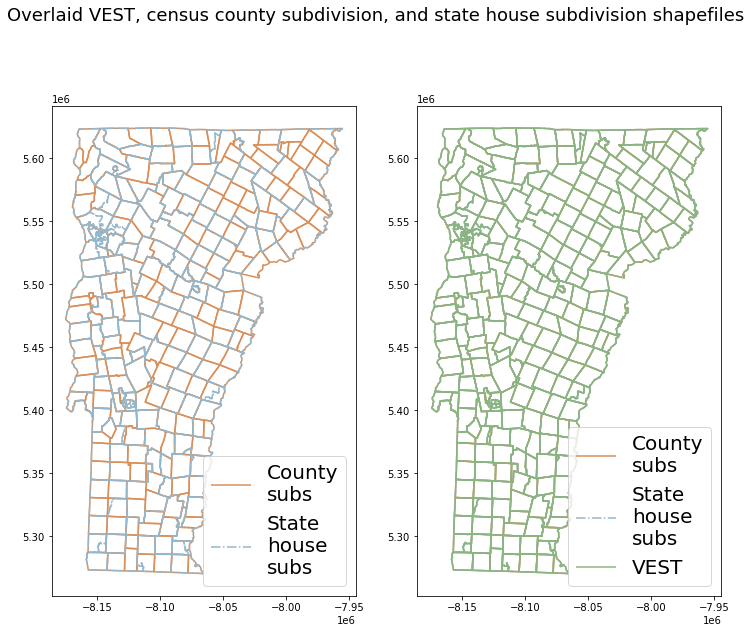

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12,10))
ax = ax.flatten()

census_county_sub.exterior.plot(ax=ax[0], color="#D88F5A", label="County\nsubs")
state_house.exterior.plot(ax=ax[0], label="State\nhouse\nsubs", linestyle="-.", color="#93B8CD")
ax[0].legend(loc="lower right", prop={"size": 20})

census_county_sub.exterior.plot(ax=ax[1], color="#D88F5A", label="County\nsubs")
state_house.exterior.plot(ax=ax[1], label="State\nhouse\nsubs", color="#93B8CD", linestyle="-.")
vest_df.exterior.plot(ax=ax[1], label="VEST", color="#89B580")
ax[1].legend(loc="lower right", prop={"size": 20})

fig.suptitle("Overlaid VEST, census county subdivision, and state house subdivision shapefiles", fontsize=18)

print("Number of census county subdivision geometries:", len(census_county_sub))
print("Number of state house subdivision geometries:", len(state_house))
print()

#### Perform overlay operation to combine boundaries.

In [69]:
recreated_shapes = gp.overlay(census_county_sub, state_house, how="identity")
recreated_shapes = recreated_shapes.to_crs(CRS)

<ipython-input-69-b47bd102c334>:2: UserWarning: `keep_geom_type=True` in overlay resulted in 696 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  recreated_shapes = gp.overlay(census_county_sub, state_house, how="identity")


#### Check the number of resulting precincts.

In [71]:
print(recreated_shapes.shape)
recreated_shapes.head()

(284, 125)


,OBJECTID_1,STATEFP10,COUNTYFP10,COUSUBFP10,COUSUBNS10,GEOID10,NAME10,NAMELSAD10,LSAD10,CLASSFP10,MTFCC10,CNECTAFP10,NECTAFP10,NCTADVFP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,SUMLEV,LOGRECNO,STATE,COUNTY,COUSUB,GEOID,P0030001,P0030002,P0030003,P0030004,P0030005,P0030006,P0030007,P0030008,P0040003,P0060002,P0060003,P0060004,P0060005,P0060006,P0060007,P0120002,P0120003,P0120004,P0120005,P0120006,P0120007,P0120008,P0120009,P0120010,P0120011,P0120012,P0120013,P0120014,P0120015,P0120016,P0120017,P0120018,P0120019,P0120020,P0120021,P0120022,P0120023,P0120024,P0120025,P0120026,P0120027,P0120028,P0120029,P0120030,P0120031,P0120032,P0120033,P0120034,P0120035,P0120036,P0120037,P0120038,P0120039,P0120040,P0120041,P0120042,P0120043,P0120044,P0120045,P0120046,P0120047,P0120048,P0120049,P0130001,P0130002,P0130003,P0150001,P0170001,P0190008,P0190009,P0290026,P0350001,P0360002,P0360003,P0370001,H00010001,H0020002,H0020005,H0030002,H0030003,H0040002,H0040003,H0040004,H0050006,ShapeSTAre_1,ShapeSTLen_1,OBJECTID_2,ID,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,IDEAL_VALU,DEVIATION,F_DEVIATIO,GDB_VCGIVC,ShapeSTAre_2,ShapeSTLen_2,geometry
0,6,50,005,77125,01462245,5000577125,Waterford,Waterford town,43,T1,G4040,None,None,None,A,99237335,3690030,+44.3628794,-071.9345286,060,6679,50,005,77125,5000577125,1280,1259,9,2,4,0,2,4,12,1263,10,5,5,0,2,637,29,35,60,35,16,2,9,4,13,26,46,43,57,55,60,21,29,8,19,30,19,15,6,643,16,45,48,32,12,1,2,9,19,28,41,46,52,58,70,14,30,17,17,30,18,24,14,45.8,45.0,46.8,505,2.52,116,216,9,387,297,801,2.84,580,0,0,505,75,287,175,43,62,1.029251e+08,43092.965405,13,15,CAL-1,1,None,Caledonia-1,4162,4172,-10,-0.0024,119.84,3.110151e+08,104969.626657,"POLYGON ((-8018965.643 5525743.702, -8017839.4..."
1,65,50,005,02875,01462034,5000502875,Barnet,Barnet town,43,T1,G4040,None,None,None,A,109437158,3428538,+44.3126302,-072.0667786,060,4388,50,005,02875,5000502875,1708,1652,15,11,5,0,2,23,12,1675,21,23,8,0,4,832,51,52,58,33,22,7,3,27,42,50,36,34,60,74,99,27,38,27,22,33,9,15,13,876,51,60,49,40,21,7,7,22,41,47,43,43,74,80,89,36,33,13,22,20,36,18,24,45.3,45.1,45.4,666,2.52,143,256,30,481,378,1030,2.93,950,0,0,666,284,359,201,106,233,1.128608e+08,52444.318296,13,15,CAL-1,1,None,Caledonia-1,4162,4172,-10,-0.0024,119.84,3.110151e+08,104969.626657,"POLYGON ((-8035827.206 5508497.896, -8035454.3..."
2,74,50,005,61525,01462195,5000561525,Ryegate,Ryegate town,43,T1,G4040,None,None,None,A,94473689,760101,+44.2222486,-072.1109090,060,5868,50,005,61525,5000561525,1174,1143,6,3,2,1,3,16,8,1159,9,14,4,1,3,582,40,35,25,26,13,9,2,16,31,31,38,35,26,52,53,17,35,20,13,31,14,13,7,592,32,36,26,25,14,5,7,16,28,34,35,38,40,45,57,20,39,16,14,17,18,16,14,44.3,42.0,45.0,478,2.46,87,186,0,335,238,712,2.84,620,0,0,478,142,245,161,72,109,9.522922e+07,44718.611190,13,15,CAL-1,1,None,Caledonia-1,4162,4172,-10,-0.0024,119.84,3.110151e+08,104969.626657,"MULTIPOLYGON (((-8019837.943 5489725.530, -801..."
3,1,50,005,62200,01462199,5000562200,St. Johnsbury,St. Johnsbury town,43,T1,G4040,None,None,None,A,94250348,917562,+44.4603077,-072.0049436,060,5992,50,005,62200,5000562200,7603,7271,59,51,89,0,28,105,114,7371,94,117,103,1,28,3768,247,221,227,165,99,60,45,154,253,220,228,233,308,272,277,92,141,76,90,100,89,83,88,3835,220,212,213,139,96,44,37,136,194,213,214,213,296,314,300,100,150,67,83,134,131,142,187,41.8,39.3,44.7,3158,2.27,462,822,446,1870,1593,3696,2.83,3522,0,0,3158,364,1100,684,1374,55,9.516467e+07,40455.616887,15,17,CAL-3,2,None,Caledonia-3,7603,8344,-741,-0.0888,36.67,9.516467e+07,40455.616887,"POLYGON ((-8024337.588 5544770.201, -8024188.4..."
4,4,50,005,71575,01462224,5000571575,Sutton,Sutton town,43,T1,G4040,None,None,None,A,98880027,507376,+44.6650706,-072.0359728,060,6503,50,005,71575,5000571575,1029,996,1,2,0,0,6,24,17,1019,3,18,5,1,10,551,38,38,36,15,11,4,5,19,30,28,28,42,43,37,56,21,20,10,15,18,12,19,6,478,25,27,19,30,11,4,2,17,33,25,35,28,37,43,43,15,20,9,17,9,9,13,7,42.2,42.6,41.8,403,2.55,73,156,0,290,223,612,2.88,486,0,0,403,83,223,118,62,4

#### Use unique index of vest_df to join with geometries in recreated_shapes. 

In [80]:
geoms = []
ids = []

election_df = election_df.to_crs(CRS)

weird_idxs = []

for i in range(len(recreated_shapes)):
    geom = recreated_shapes["geometry"].iloc[i]
    
    vest_match = election_df[election_df["geometry"].intersects(geom)].copy()
    orig_idxs = vest_match.index.to_numpy()
    
    vest_match = vest_match["geometry"]

    area_same = vest_match.intersection(geom, align=False).area.to_numpy()

    max_idx = np.argmax(area_same)
    area_same = area_same[max_idx]

    try:
        vest_idx = orig_idxs[max_idx]
    except IndexError:
        print("Index error for i =", i)
        weird_idxs.append(i)
        continue

    geoms.append(geom)
    ids.append(vest_idx)
    

# dataframe that will be used to join the raw geometry row to vest
geom2id = pd.DataFrame(data={"index" : ids, "geometry_y" : geoms})
print("geom2id dimensions:", geom2id.shape)

geom2id dimensions: (284, 2)


In [81]:
display(geom2id.head())
geom2id = geom2id.sort_values("index")

geom2id.reset_index(inplace=True)
display(geom2id.head())
election_df["geometry_y"] = geom2id["geometry_y"]


vest_shapes = gp.GeoDataFrame(election_df["STATEFP"],geometry=election_df["geometry"])
raw_shapes = gp.GeoDataFrame(election_df["STATEFP"],geometry=election_df["geometry_y"], crs=CRS)

,index,geometry_y
0,57,"POLYGON ((-8018965.64313664 5525743.702498256,..."
1,42,POLYGON ((-8035827.206420447 5508497.896088349...
2,51,(POLYGON ((-8019837.942507572 5489725.53046095...
3,53,POLYGON ((-8024337.587759871 5544770.200748877...
4,55,POLYGON ((-8027749.752850572 5582190.657340027...


,level_0,index,geometry_y
0,59,0,POLYGON ((-8175048.036811541 5472579.657695195...
1,64,1,POLYGON ((-8172243.231079604 5462690.480567586...
2,72,2,POLYGON ((-8142876.481377687 5492839.554982428...
3,43,3,POLYGON ((-8155072.756135776 5459604.770143382...
4,60,4,POLYGON ((-8170954.485306844 5489103.038844403...


In [82]:
print(vest_shapes.shape)
print(raw_shapes.shape)

differences = np.abs(vest_shapes.area.to_numpy() - raw_shapes.area.to_numpy()) / 1e6
print(len(differences))

(284, 2)
(284, 2)
284


#### Display the precincts that contain significant shape differences.

There are 284 precincts.
245 have a difference of less than .1 km^2.
278 have a difference of less than 1 km^2.

The following precincts have differences of larger than 1 km^2:
['Windsor-Orange-2 State House District'
 'Essex-Caledonia State House District'
 'Orange-Caledonia State House District'
 'Essex-Caledonia State House District'
 'Essex-Caledonia-Orleans State House District'
 'Essex-Caledonia-Orleans State House District'
 'Franklin-5 State House District']


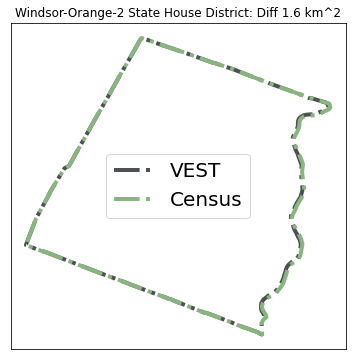

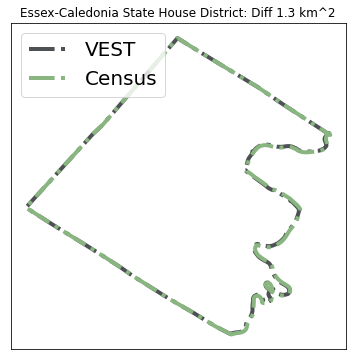

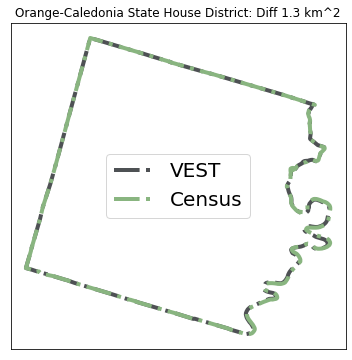

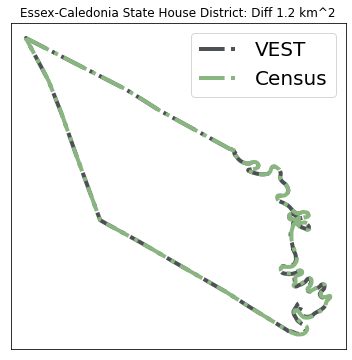

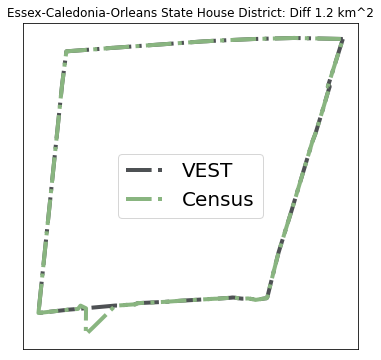

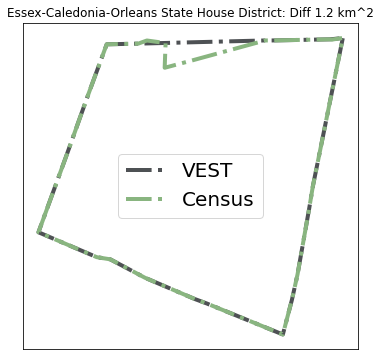

In [94]:
print(f"There are {len(differences)} precincts.")
print(f"{len(differences[differences < .1])} have a difference of less than .1 km^2.")
print(f"{len(differences[differences < 1])} have a difference of less than 1 km^2.")
print()

print("The following precincts have differences of larger than 1 km^2:")
low_idxs = np.argsort(differences)[::-1][:len(differences[differences > 1]) + 1]
print((election_df.iloc[low_idxs]["NAMELSAD_1"].to_numpy()))

for i in range(len(differences[differences > 1])):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    
    try: 
        ax.plot(*vest_shapes["geometry"].iloc[low_idxs[i]].exterior.xy, c="#4E5154", label="VEST", ls="-.", lw=4)
    except AttributeError:
        for g in vest_shapes["geometry"].iloc[low_idxs[i]].geoms:
            ax.plot(*g.exterior.xy, color="#4E5154", label="VEST")
            
    try: 
        ax.plot(*raw_shapes["geometry"].iloc[low_idxs[i]].exterior.xy, c="#89B580", label="Census", ls="-.", lw=4)
    except AttributeError:
        for g in raw_shapes["geometry"].iloc[low_idxs[i]].geoms:
            ax.plot(*g.exterior.xy, color="#89B580", label="Census")    
    
    
    ax.legend(prop={"size" : 20})
    name = election_df["NAMELSAD_1"].iloc[low_idxs[i]]
    ax.set_title(name + f": Diff {round(differences[low_idxs[i]],1)} km^2")
    ax.set_yticks([])
    ax.set_xticks([])
        
    fig.savefig(f"incorrect_precincts/{i}")

